In [52]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import scipy.ndimage
from scipy.optimize import curve_fit
from scipy import interpolate
import pylab
import cmath

In [199]:
# input parameters for a perfect 1:1 focus arrangement using a single mirror deflecting horizontally
# same as LSBL1378 (4.96, 1.65, 0.551 nm wavelength; 11.86, 6.84, 3.95 um source sigma;  250, 750, 2250 eV)
anglefromnormal = 88.75 # degrees
sourcesigma = 11.86 # microns
wavelength = 4.96 # nanometers
conjugate = 15 # meters
length = 150 # mirror length millimeters
nlength = 301 #odd number of evenly spaced height samples along length
width = 3 # mirror width millimeters
nwidth = nlength #odd number of evenly spaced height samples across width
lengthstep = length/(nlength-1) # millimeters
widthstep = width/(nwidth-1) # millimeters

pixel-by-pixel sum of footprint array 0.9964240581643738


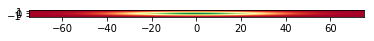

In [200]:
# compute normalized 2D gaussian illumination intensity footprint on surface
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-length/2, length/2, nlength)  # mm
y = np.linspace(-width/2, width/2, nwidth)  # mm
dx=length/(nlength-1)
dy=width/(nwidth-1)
X, Y = np.meshgrid(x, y)
footprintsigma=(wavelength*conjugate)/(4*np.pi*sourcesigma)

footprint = gaus2d(X,Y,0,0,(footprintsigma/np.cos((anglefromnormal*np.pi/180))),footprintsigma)*dx*dy

print('pixel-by-pixel sum of footprint array',   np.sum(footprint))

fig, ax = plt.subplots()
im = ax.imshow(footprint, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-length/2, length/2, -width/2, width/2],
               vmax=footprint.max(), vmin=footprint.min())

plt.show()

In [201]:
# spatial frequencies along the mirror (tangential)
fall=np.linspace(0, (nlength-1)/length, num=nlength) # all the inverse wavelengths
fplot=fall[1:int((nlength-1)/2+1)] # up to and including folding frequency,excludes zero frequency
fmeaningful=fall[:int((nlength-1)/2+1)] # up to and including folding frequency,includes zero frequency
deltaf=1/(length)
#fake out the zero spatial frequency (for fft fractal smoothing)
fall[0]=1

In [202]:
# for fractal filter we will need the same domain of spatial
# frequencies in both directions, a square mirror

lengthfractal = length # MILLImeters
nlengthfractal = nlength #odd number of evenly spaced height samples along length
widthfractal = lengthfractal # MILLImeters
nwidthfractal = nlengthfractal #odd number of evenly spaced height samples across width
lengthstepfractal = lengthfractal/(nlengthfractal-1) # millimeters
widthstepfractal = widthfractal/(nwidthfractal-1) # millimeters

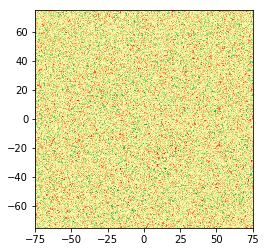

In [290]:
# generate a rough surface by starting with random
# height errors, pixel-by-pixel
np.random.seed(196378014) # fixing random state for a particular set of errors
peakheighterror = 5 # max/min height error in NANOmeters (value not important, will be normalized later)

# square array for 2D fractal smoothing.....

squaresurface = np.random.rand(nwidthfractal,nlengthfractal)
squaresurface = squaresurface*2*peakheighterror-peakheighterror # random height errors in nanometers

Z = squaresurface

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-lengthfractal/2, lengthfractal/2, -widthfractal/2, widthfractal/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

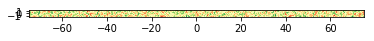

In [291]:
# map onto narrow mirror with interpolation

# narrow array for 2d Gaussian smoothing......

xsquare = np.linspace(-lengthfractal/2, lengthfractal/2, nlengthfractal)  # mm
ysquare = np.linspace(-widthfractal/2, widthfractal/2, nwidthfractal)  # mm

f = interpolate.interp2d(xsquare, ysquare, squaresurface, kind='cubic')

rawsurface = f(x,y)

#print('rawsurface',rawsurface)

rawmean = np.average(rawsurface)
rawsurface = rawsurface - rawmean
rawrms = np.sqrt(np.mean(rawsurface**2))
rawsurface=rawsurface/rawrms

# raw surface has zero mean and rms=1nm

#print(np.sqrt(np.mean(rawsurface**2)))
#print(rawsurface)

Z=rawsurface
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-length/2, length/2, -width/2, width/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

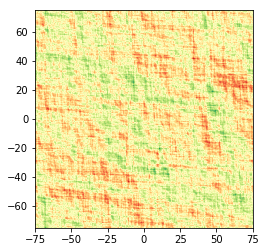

In [292]:
# now smooth the (square) raw surface with a fractal distribution of spatial frequency

beta = 1.1

# select a (positive) value to control fractal psd
# due to 'stochasticity', choose beta=1.1, 1.6, 2.1 and get beta about 1.0, 1.5, 2.0
# Take the 2-dimensional FFT of the surface
twodimensionalfft = np.fft.fft2(squaresurface)

Fyall, Fxall = np.meshgrid(fall, fall)
#fractalfilter is the power law spatial frequency distribution
fractalfilter = (Fxall*Fyall)**(-beta/2)
fractalfft=twodimensionalfft*fractalfilter
squarefractalsurface=np.real(np.fft.ifft2(fractalfft))

#print(squarefractalsurface)

Z=squarefractalsurface

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-lengthfractal/2, lengthfractal/2, -widthfractal/2, widthfractal/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

# these 45 degree bands are a correlation between x and y that arises
# inevitably as the higher spatial frequencies are suppressed at values of
# beta larger than about beta=2


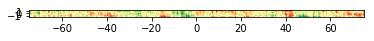

In [293]:
# map onto narrow mirror with interpolation

xsquare = np.linspace(-lengthfractal/2, lengthfractal/2, nlengthfractal)  # mm
ysquare = np.linspace(-widthfractal/2, widthfractal/2, nwidthfractal)  # mm

f = interpolate.interp2d(xsquare, ysquare, squarefractalsurface, kind='cubic')

fractalsurface = f(x,y)

fractalmean = np.average(fractalsurface)
fractalsurface = fractalsurface - fractalmean
fractalrms = np.sqrt(np.mean(fractalsurface**2))
fractalsurface=fractalsurface/fractalrms

# fractal surface has zero mean and rms=1nm

#print(np.sqrt(np.mean(fractalsurface**2)))
#print(fractalsurface)

Z=fractalsurface
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-length/2, length/2, -width/2, width/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

In [294]:
# compute amplitude weighted rms height error and use it to estimate the Strehl ratio (valid for small errors)
fractalrms = np.sqrt(np.mean(fractalsurface**2))
weightedfractalrms = np.sqrt(   (np.sum(np.sqrt(footprint)*fractalsurface**2))  /  np.sum(np.sqrt(footprint))   )
#print(np.sum(footprint))
print('un-weighted fractal surface, rms =',fractalrms,'nm')
print('footprint-amplitude-weighted fractal surface, rms =',weightedfractalrms,'nm')
fractalstrehl=np.exp(-((weightedfractalrms*4*np.pi*np.cos((anglefromnormal*np.pi/180)))/wavelength)**2)
print('Strehl ratio illuminating this fractal surface =',fractalstrehl)

un-weighted fractal surface, rms = 0.9999999999999999 nm
footprint-amplitude-weighted fractal surface, rms = 0.9823934030282544 nm
Strehl ratio illuminating this fractal surface = 0.9970563029950653


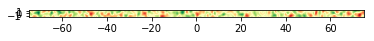

In [295]:
# now smooth the raw surface by convoluting surface height distribution with a 2D gaussian

sigma_x = .5 # MILLImeters, here x is along the mirror, same sigma across mirror for 2d smoothing
# select a value to control spatial frequency distribution after smoothing

sigma_y=sigma_x
pixels_x = sigma_x/lengthstep # pixels
pixels_y = sigma_y/widthstep # pixels

sigma = [pixels_y, pixels_x]
filteredsurface = sp.ndimage.filters.gaussian_filter(rawsurface, sigma, mode='constant')

filteredmean = np.average(filteredsurface)
filteredsurface = filteredsurface - filteredmean
filteredrms = np.sqrt(np.mean(filteredsurface**2))
filteredsurface=filteredsurface/filteredrms

# filtered surface has zero mean and rms=1nm

#print(np.sqrt(np.mean(filteredsurface**2)))
#print(filteredsurface)

Z=filteredsurface
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-length/2, length/2, -width/2, width/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

In [296]:
# compute amplitude weighted rms height error and use it to estimate the Strehl ratio (valid for small errors)
filteredrms = np.sqrt(np.mean(filteredsurface**2))
weightedfilteredrms = np.sqrt(   (np.sum(np.sqrt(footprint)*filteredsurface**2))  /  np.sum(np.sqrt(footprint))   )
#print(np.sum(footprint))
print('un-weighted filtered surface, rms =',filteredrms,'nm')
print('footprint-amplitude-weighted filtered surface, rms =',weightedfilteredrms,'nm')
filteredstrehl=1-((weightedfilteredrms*4*np.pi*np.cos((anglefromnormal*np.pi/180)))/wavelength)**2
print('Strehl ratio illuminating this filtered surface =',filteredstrehl)

un-weighted filtered surface, rms = 1.0 nm
footprint-amplitude-weighted filtered surface, rms = 0.9911069613079129 nm
Strehl ratio illuminating this filtered surface = 0.9969994332994201


In [297]:
# coordinate along the center of the mirror is w
w=np.linspace(-length/2, length/2, num=nlength)
#print(w)

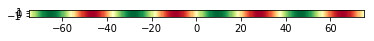

In [298]:
# make a 2D fake surface to check fft

# generate a sinusoidal fake profile
fakeprofile=(1.4166)*np.sin(2*np.pi*w/(length/4))
# 8 periods along mirror

#plt.plot(w,fakeprofile, 'b')
#plt.axis([-length/2, length/2,-peakheighterror,peakheighterror])
#plt.ylabel('fake height error (nm)')
#plt.xlabel('length along mirror (mm)')
#plt.show()

fakesurface = np.ones((nwidth,nlength))

for jj in range(0,nlength):
    for ii in range(0,nwidth):
        fakesurface[ii,jj] = fakesurface[ii,jj]*fakeprofile[jj]

fakemean = np.average(fakesurface)
fakesurface = fakesurface - fakemean
fakerms = np.sqrt(np.mean(fakesurface**2))
fakesurface=fakesurface/fakerms

# fake surface has zero mean and rms=1nm

Z=fakesurface
fig, ax = plt.subplots()
im = ax.imshow(Z, cmap=cm.RdYlGn,
               origin='lower', extent=[-length/2, length/2, -width/2, width/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

In [299]:
# compute amplitude weighted rms height error and use it to estimate the Strehl ratio (valid for small errors)
fakerms = np.sqrt(np.mean(fakesurface**2))
weightedfakerms = np.sqrt(   (np.sum(np.sqrt(footprint)*fakesurface**2))  /  np.sum(np.sqrt(footprint))   )
#print(np.sum(footprint))
print('un-weighted fake surface, rms =',fakerms,'nm')
print('footprint-amplitude-weighted fake surface, rms =',weightedfakerms,'nm')
fakestrehl=1-((weightedfakerms*4*np.pi*np.cos((anglefromnormal*np.pi/180)))/wavelength)**2
print('Strehl ratio illuminating this fake surface =',fakestrehl)

un-weighted fake surface, rms = 0.9999999999999998 nm
footprint-amplitude-weighted fake surface, rms = 1.0019882213021023 nm
Strehl ratio illuminating this fake surface = 0.9969331858047313


In [300]:
# make lines along center of mirror

rawprofile = rawsurface[int((nwidth-1)/2)]
filteredprofile = filteredsurface[int((nwidth-1)/2)]
fractalprofile = fractalsurface[int((nwidth-1)/2)]
fakeprofile = fakesurface[int((nwidth-1)/2)]

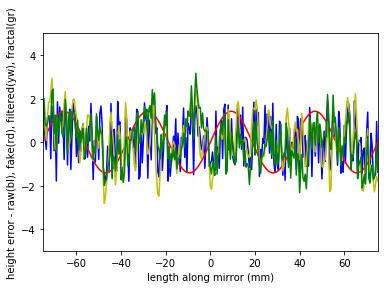

In [301]:
plt.plot(w,rawprofile, 'b')
plt.plot(w,fakeprofile, 'r')
plt.plot(w,filteredprofile, 'y')
plt.plot(w,fractalprofile, 'g')
plt.axis([-length/2, length/2,-5,5])
plt.ylabel('height error - raw(bl), fake(rd), filtered(yw), fractal(gr)')
plt.xlabel('length along mirror (mm)')
plt.show()

In [302]:
rms = np.sqrt(np.mean(rawprofile**2))
print('raw profile, rms =',rms,'nm')
rms = np.sqrt(np.mean(filteredprofile**2))
print('filtered profile, rms =',rms,'nm')
rms = np.sqrt(np.mean(fractalprofile**2))
print('fractal profile, rms =',rms,'nm')
rms = np.sqrt(np.mean(fakeprofile**2))
print('fake profile, rms =',rms,'nm')

raw profile, rms = 1.0604311513619826 nm
filtered profile, rms = 1.0596691340119888 nm
fractal profile, rms = 1.0441675102850412 nm
fake profile, rms = 0.9999999999999999 nm


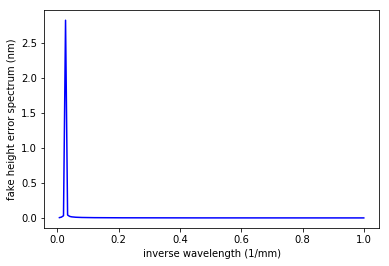

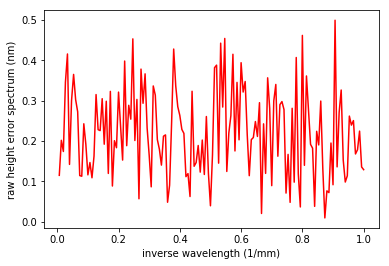

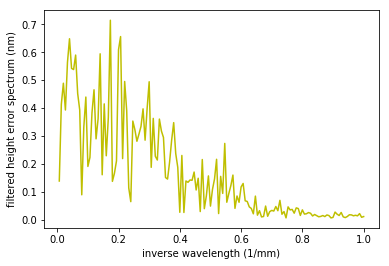

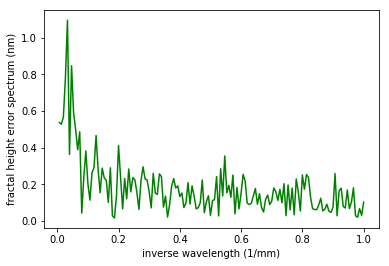

In [303]:
fakespectrum=np.fft.fft(fakeprofile)
plt.plot(fplot,(4/nlength)*abs(fakespectrum[1:int((nlength-1)/2)+1]),'b')
plt.ylabel('fake height error spectrum (nm)')
plt.xlabel('inverse wavelength (1/mm)')
plt.show()

rawspectrum=np.fft.fft(rawprofile)
plt.plot(fplot,(4/nlength)*abs(rawspectrum[1:int((nlength-1)/2)+1]),'r')
plt.ylabel('raw height error spectrum (nm)')
plt.xlabel('inverse wavelength (1/mm)')
plt.show()

filteredspectrum=np.fft.fft(filteredprofile)
plt.plot(fplot,(4/nlength)*abs(filteredspectrum[1:int((nlength-1)/2+1)]), 'y')
plt.ylabel('filtered height error spectrum (nm)')
plt.xlabel('inverse wavelength (1/mm)')
plt.show()

fractalspectrum=np.fft.fft(fractalprofile)
plt.plot(fplot,(4/nlength)*abs(fractalspectrum[1:int((nlength-1)/2)+1]), 'g')
plt.ylabel('fractal height error spectrum (nm)')
plt.xlabel('inverse wavelength (1/mm)')
plt.show()

In [304]:
# fractal PSD

# make psd that is normalized so that integral from zero to folding frequency is the rms
fractalpsd=(2/(deltaf*((nlength-1))**2))*(abs(fractalspectrum[:int((nlength-1)/2+1)]))**2
# don't count zero frequency twice
fractalpsd[0]=fractalpsd[0]/2

In [305]:
rms = np.sqrt(np.sum(fractalpsd)*deltaf*(len(fractalpsd)-1)/len(fractalpsd))
print('fractal psd, rms =',rms,'nm')

fractal psd, rms = 1.044173272782994 nm


In [306]:
# fit power law to PSD of fractal height, exclude zero frequency
logfractalpsdtrunc=np.log10(fractalpsd[1:int((nlength-1)/2+1)])
logfplottrunc=np.log10(fplot[0:])

# test is the function to fit
def test(x, a, b): 
    return a*x+b 
  
param, param_cov = curve_fit(test, logfplottrunc, logfractalpsdtrunc)

logfractalpsd=np.log10(fractalpsd[1:int((nlength-1)/2+1)])
logfplot=np.log10(fplot)

fit=param[0]*logfplot+param[1]
beta=param[0]

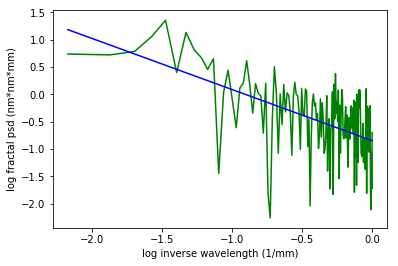

power law exponent -0.9335352007560089


In [308]:
plt.plot(logfplot,logfractalpsd, 'g')
plt.plot(logfplot,fit, 'b')
plt.ylabel('log fractal psd (nm*nm*mm)')
plt.xlabel('log inverse wavelength (1/mm)')
plt.show()
print('power law exponent',beta)

In [309]:
# filtered PSD

# make psd that is normalized so that integral from zero to folding frequency is the rms
filteredpsd=(2/(deltaf*((nlength-1))**2))*(abs(filteredspectrum[:int((nlength-1)/2+1)]))**2
# don't count zero frequency twice
filteredpsd[0]=filteredpsd[0]/2

In [310]:
rms = np.sqrt(np.sum(filteredpsd)*deltaf*(len(filteredpsd)-1)/len(filteredpsd))
print('filtered psd, rms =',rms,'nm')

filtered psd, rms = 1.0596749820595053 nm


In [311]:
# fit power law to PSD of filtered height, ignore 8 lowest spatial frquencies
logfilteredpsdtrunc=np.log10(filteredpsd[9:int((nlength-1)/2+1)])
logfplottrunc=np.log10(fplot[8:])

# test is the function to fit
def test(x, a, b): 
    return a*x+b 
  
param, param_cov = curve_fit(test, logfplottrunc, logfilteredpsdtrunc)

logfilteredpsd=np.log10(filteredpsd[1:int((nlength-1)/2+1)])
logfplot=np.log10(fplot)

fit=param[0]*logfplot+param[1]
beta=param[0]

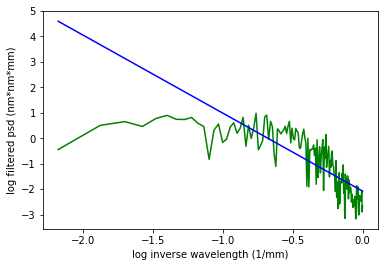

power law exponent -3.0653109529216382


In [312]:
plt.plot(logfplot,logfilteredpsd, 'g')
plt.plot(logfplot,fit, 'b')
plt.ylabel('log filtered psd (nm*nm*mm)')
plt.xlabel('log inverse wavelength (1/mm)')
plt.show()
print('power law exponent',beta)

In [313]:
# diffraction integral
# 301 x 301 pixellated pupil and 41 x 21 pixellated image takes about 15 minutes on laptop
def integral(compleximage):
    j=cmath.sqrt(-1)
    for ip in range(len(xp)):
        for jp in range(len(yp)):
            integrand=complex(0,0)
            for ir in range(len(xr)):
                for jr in range(len(yr)):
                    u=np.sqrt(xr[ir]**2+yr[jr]**2+u0**2)
                    v=np.sqrt((xp[ip]-xr[ir])**2+(yp[jp]-yr[jr])**2+v0**2)
                    #element=0
                    element=(cmath.exp(j*k*(u-u0+v-v0-ulens[jr,ir]+uerror[jr,ir]))/v)*transverseamplitude[jr,ir]
                    # spreading of light on lens is taken care of by 'transverseamplitude'
                    # so no need to divide by u
                    # divide by v for spreading between lens and image
                    # put u-u0+v-v0 in exponent for net phase shift from source to image
                    # put ulens in exponent for 1:1 focusing
                    # put uerror in exponent for surface height errors
                    integrand=integrand+element
                    #print(ip,jp,ir,jr)
                    #print(v)
            compleximage[jp,ip]=integrand
    return compleximage
        

In [ ]:
# prepare to compute image as 2d diffraction integral over the lens aperture
# for a point source making a gaussian illumination footprint on the mirror


imagelength=0.12 # width, height of image plane   mm
imagewidth=0.06 # width, height of image plane   mm
#(use these values to see focal spot)

#imagelength=0.5 # width, height of image plane   mm
#imagewidth=0.1 # width, height of image plane   mm
#(use these values to see diffraction from 5-period fake surface)

nalongimage=41  # odd number of pixels along image plane
nacrossimage=21

u0 = conjugate*1000  # mm
v0 = conjugate*1000  # mm
k=2*np.pi*1000000/wavelength # mm**-1

# p is the transverse coordinate in the image plane (mm)
xp = np.linspace(-imagelength/2, imagelength/2, nalongimage)
yp = np.linspace(-imagewidth/2, imagewidth/2, nacrossimage)
dxp=imagelength/(nalongimage-1)
dyp=imagewidth/(nacrossimage-1)
Xp, Yp = np.meshgrid(xp, yp)
# initialize image
emptyimage=Xp*complex(0,0)

#Z=np.abs(compleximage)
#fig, ax = plt.subplots()
#im = ax.imshow(Z, cmap=cm.RdYlGn,
#               origin='lower', extent=[-imagelength/2, imagelength/2, -imagewidth/2, imagewidth/2],
#               vmax=Z.max(), vmin=Z.min())
#
#plt.show()

# r is the transverse coordinate at the mirror pole (mm)
xr=x*np.cos(anglefromnormal*np.pi/180)
yr=y
Xr, Yr = np.meshgrid(xr, yr)
dxr=dx*np.cos(anglefromnormal*np.pi/180)
dyr=dy
transverseamplitude=np.sqrt(footprint)/np.cos(anglefromnormal*np.pi/180)

#path length modification for 1:1 focusing lens
ulens = Xr*0
for ir in range(len(xr)):
    for jr in range(len(yr)):
        ulens[jr,ir]=2*(np.sqrt(xr[ir]**2+yr[jr]**2+u0**2)-u0)
        

# optional surface error (nm),  these all have 1nm rms height error
#surfaceerror = filteredsurface
surfaceerror = fractalsurface
#surfaceerror = fakesurface

#get average tangential slope across 2D surface
deltaxtrunc, deltasurfacetrunc = np.meshgrid(x[1:], y)
for j in range(len(y)):
    for i in range(1,len(x)):           
        deltasurfacetrunc[j,i-1]=surfaceerror[j,i]-surfaceerror[j,i-1]
        deltaxtrunc[j,i-1]=X[j,i]-X[j,i-1]    
#print('surfaceerror',surfaceerror)
#print('deltasurfacetrunc',deltasurfacetrunc)
#print('X',X)
#print('deltaxtrunc',deltaxtrunc)    
xslope=np.mean(deltasurfacetrunc/deltaxtrunc)  # units are nm/mm
#print('xslope',xslope)

#get average sagittal slope across 2D surface
deltaytrunc, deltasurfacetrunc = np.meshgrid(x, y[1:])
for i in range(len(x)):
    for j in range(1,len(y)):            
        deltasurfacetrunc[j-1,i]=surfaceerror[j,i]-surfaceerror[j-1,i]
        deltaytrunc[j-1,i]=Y[j,i]-Y[j-1,i]       
#print('surfaceerror',surfaceerror)
#print('deltasurfacetrunc',deltasurfacetrunc)
#print('Y',Y)
#print('deltaytrunc',deltaytrunc)      
yslope=np.mean(deltasurfacetrunc/deltaytrunc)  # units are nm/mm
#print('yslope',yslope)

# correct for the average surface slope, makes no
# significant difference to the computed image or the extracted Strehl ratio
slopecorrection = X*xslope + Y*yslope
surfaceerror = surfaceerror - slopecorrection
    
surfaceerrormean = np.mean(surfaceerror)
surfaceerror = surfaceerror - surfaceerrormean
surfaceerrorrms = np.sqrt(np.mean(surfaceerror**2))
surfaceerror=surfaceerror/surfaceerrorrms

# surface has zero mean and rms=1nm
print('surface mean',np.mean(surfaceerror))
print('surface rms',np.sqrt(np.mean(surfaceerror**2)))
        
# multiplier to scale up the surface from its normalized 1nm rms
# make the first multiplier zero, it is used for normalization
multiplierlist=[0,5,10,15]
maxpixellist=[0,0,0,0]
centralpixellist=[0,0,0,0]
weightedrmslist=[0,0,0,0]
strehllist=[0,0,0,0]

#loop over values of multiplier......

for i in range(len(multiplierlist)):
    multiplier = multiplierlist[i]

    uerror=2*surfaceerror*multiplier*np.cos(anglefromnormal*np.pi/180)/1000000
    # path length error converted to mm
        
    #compleximage works on the surface with rms=1nm and a multiplier to scale up the errors
    compleximage=emptyimage
    compleximage = integral(emptyimage) # !!!! this calls the integral, takes ages   !!!
    
    # the mysterious denominator normalizes to peak of perfect image, or use 1.0
    image=(np.abs((compleximage*dxr*dyr*1000000)/(2*wavelength))**2)/1.0 

    maxpixellist[i]=np.amax(image)
    centralpixellist[i]=image[int((nacrossimage-1)/2),int((nalongimage-1)/2)]
    
    #weightedrms = np.sqrt(np.sum(footprint*surfaceerror**2))
    weightedrmslist[i] = np.sqrt(   (np.sum(np.sqrt(footprint)*surfaceerror**2))  /  np.sum(np.sqrt(footprint))   )
    strehllist[i]=np.exp(-((multiplier*weightedrmslist[i]*4*np.pi*np.cos((anglefromnormal*np.pi/180)))/wavelength)**2)
    #print('estimated Strehl ratio illuminating this surface =',strehl)

surface mean -2.1370944635779662e-17
surface rms 1.0


In [285]:
print('multipliers:  ',multiplierlist)
print()
print('maximum pixels:   ',maxpixellist)
print('strehl from maximum pixels',maxpixellist/maxpixellist[0])
print()
print('central pixels:    ',centralpixellist)
print('strehl from central pixels',centralpixellist/centralpixellist[0])
print()
print('footprint-amplitude weighted rms:   ',weightedrmslist)
print('footprint-amplitude weighted strehl:   ',strehllist/strehllist[0])

multipliers:   [0, 5, 10, 15]

maximum pixels:    [58.21573252824607, 53.83084669713577, 42.598448600692905, 29.2602499874722]
strehl from maximum pixels [1.         0.92467868 0.73173431 0.50261757]

central pixels:     [58.21573252824607, 53.83084669713577, 42.53093307702759, 28.65440956914021]
strehl from central pixels [1.         0.92467868 0.73057456 0.49221075]

footprint-amplitude weighted rms:    [1.0186758928017243, 1.0186758928017243, 1.0186758928017243, 1.0186758928017243]
footprint-amplitude weighted strehl:    [1.         0.92381315 0.72834403 0.49006905]


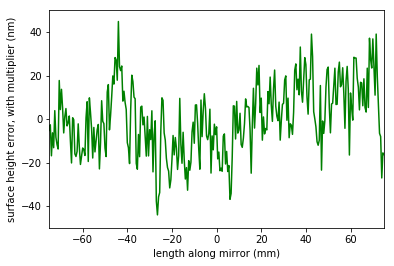

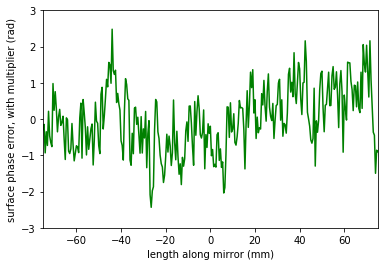

estimated Strehl ratio illuminating this surface = 0.2798913037901287
footprint weighted rms height error = 15.353871857524577


In [286]:
#plots and results with most recent value of 'multiplier'
plt.plot(w,multiplier*surfaceerror[int((nwidth-1)/2)], 'g')
plt.axis([-length/2, length/2,-50,50])
plt.ylabel('surface height error, with multiplier (nm)')
plt.xlabel('length along mirror (mm)')
plt.show()
plt.plot(w,(uerror[int((nwidth-1)/2)])*k, 'g')
plt.axis([-length/2, length/2,-3,3])
plt.ylabel('surface phase error, with multiplier (rad)')
plt.xlabel('length along mirror (mm)')
plt.show()

weightedrms = np.sqrt(np.sum(footprint*surfaceerror**2))
strehl=1-((multiplier*weightedrms*4*np.pi*np.cos((anglefromnormal*np.pi/180)))/wavelength)**2
print('estimated Strehl ratio illuminating this surface =',strehl)

print('footprint weighted rms height error =',multiplier*weightedrms)

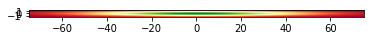

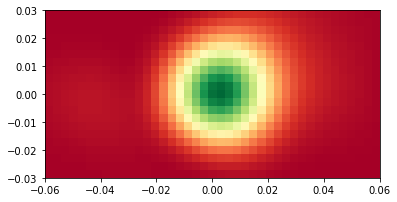

In [288]:
#debug
#for ir in range(len(xr)):
#    for jr in range(len(yr)):
#        u=np.sqrt(xr[ir]**2+yr[jr]**2+u0**2)-u0
#        transverseamplitude[jr,ir]=u


Z=transverseamplitude
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-length/2, length/2, -width/2, width/2],
               vmax=Z.max(), vmin=Z.min())

plt.show() 

#normalize to perfect image
Z=image
fig, ax = plt.subplots()
im = ax.imshow(Z, cmap=cm.RdYlGn,
               origin='lower', extent=[-imagelength/2, imagelength/2, -imagewidth/2, imagewidth/2],
               vmax=Z.max(), vmin=Z.min())

plt.show()

central pixel value 28.65440956914021
maximum pixel value 29.2602499874722


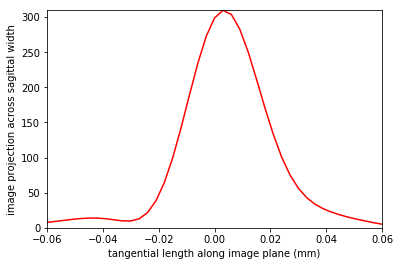

image projection rms = 0.01706571143353209 mm


In [287]:
#print('nimage',nimage)
centralpixel=image[int((nacrossimage-1)/2),int((nalongimage-1)/2)]
maximumpixel=np.amax(image)
print('central pixel value',centralpixel)
print('maximum pixel value',maximumpixel)
#print('dxr',dxr)
#print('dyr',dyr)
#print('central pixel of transverse amplitude',transverseamplitude[int((nwidth-1)/2),int((nlength-1)/2)])
#print('most recent value of delta path length in exponent',(u-u0+v-v0))
#print('most recent value of exponent, no lens',j*k*(u-u0+v-v0))
#print('complex exponential',cmath.exp(j*k*(u-u0+v-v0)))
#print(image)

#slice through middle of image
#print(len(image))
#print(int((nimage-1)/2))
imageslice=image[int((nacrossimage-1)/2)]

# sum across the width of the image and
# generate a line along tangential image plane, coordinate is xp
imageprojection = xp*0
for jp in range(len(yp)):
    imageprojection=imageprojection+image[jp]
    
plt.plot(xp,imageprojection, 'r')
plt.axis([xp[0],xp[len(xp)-1],0,np.max(imageprojection)])
plt.ylabel('image projection across sagittal width')
plt.xlabel('tangential length along image plane (mm)')
plt.show()

# compute rms image size
weightedsum=0
normalization=0
for ip in range(len(xp)):
    weightedsum=weightedsum+imageslice[ip]*xp[ip]**2
    normalization=normalization+imageslice[ip]
rms = np.sqrt(weightedsum/normalization)
print('image projection rms =',rms,'mm')

In [34]:
# code below no longer in use

In [50]:
def write_srw_surface(s,xx,yy,outFile='presurface.dat'):
    """
      write_srw_surface: writes a mesh in the SRW/presurface format    Different from SHADOW/presurface format !
      SYNTAX: 
           out = write_srw_surface(z,x,y,outFile=outFile)
      INPUTS:
           z - 2D array of heights
           x - 1D array of spatial coordinates along mirror width.
           y - 1D array of spatial coordinates along mirror length.
     
      OUTPUTS:
           out - 1=Success, 0=Failure
           outFile - output file in SHADOW format. If undefined, the
                     file is names "presurface.dat"
     
    """
    out = 1

    try:
       fs = open(outFile, 'w')
    except IOError:
       out = 0
       print ("Error: can\'t open file: "+outFile)
       return 
    else:
        # y array
        writezero=0
        fs.write(repr(writezero))
        for i in range(yy.size): 
            fs.write("\t" + repr(yy[i]) )
        fs.write("\n")
        # for each x element, the x value and the corresponding z(y)
        # profile
        for i in range(xx.size): 
            fs.write(repr(xx[i]))
            for j in range(yy.size): 
                fs.write("\t" + repr(s[j,i]) )
            fs.write("\n")
        fs.close()
        print ("write_SRW_surface: File for SRW "+outFile+" written to disk.")
        

In [607]:
def write_shadow_surface(s,xx,yy,outFile='presurface.dat'):
    """
      write_shadow_surface: writes a mesh in the SHADOW/presurface format
      SYNTAX: 
           out = write_shadow_surface(z,x,y,outFile=outFile)
      INPUTS:
           z - 2D array of heights
           x - 1D array of spatial coordinates along mirror width.
           y - 1D array of spatial coordinates along mirror length.
     
      OUTPUTS:
           out - 1=Success, 0=Failure
           outFile - output file in SHADOW format. If undefined, the
                     file is names "presurface.dat"
     
    """
    out = 1

    try:
       fs = open(outFile, 'w')
    except IOError:
       out = 0
       print ("Error: can\'t open file: "+outFile)
       return 
    else:
        # dimensions
        fs.write( repr(xx.size)+" "+repr(yy.size)+" \n" ) 
        # y array
        for i in range(yy.size): 
            fs.write(' ' + repr(yy[i]) )
        fs.write("\n")
        # for each x element, the x value and the corresponding z(y)
        # profile
        for i in range(xx.size): 
            tmps = ""
            for j in range(yy.size): 
                tmps = tmps + "  " + repr(s[j,i])
            fs.write(' ' + repr(xx[i]) + " " + tmps )
            fs.write("\n")
        fs.close()
        print ("write_shadow_surface: File for SHADOW "+outFile+" written to disk.")
        

In [289]:
# write surface height error file for SRW
# remember units are meters!
# write_srw_surface(filteredsurface/1000000000,x/1000,y/1000,outFile='bump.dat')
write_srw_surface(fractalsurface/1000000000,x/1000,y/1000,outFile='fractalsurface.dat')

write_SRW_surface: File for SRW fractalsurface.dat written to disk.


In [313]:
# Take the 2-dimensional FFT of the illuminated surface with convergent phase profile and phase errors
# and center the frequencies
extrapath=2*(np.sqrt((X*np.cos(anglefromnormal*np.pi/180)/1000)**2+(Y/1000)**2+conjugate**2)-conjugate)
phasecurvature=2*np.pi*extrapath*1000000000/wavelength
#THIS IS NOT THE CORRECT THING TO DO
# This isn't a Fourier Transform lens, can't use FFT so easily!
phaseerrormap = 4*np.pi*fakesurface*np.cos(anglefromnormal*np.pi/180)/wavelength
fftargument = footprint#*cmath.exp(-j*phasecurvature)#*cmath.exp(j*phaseerrormap)
ftimage = np.fft.fft2(fftargument)
ftimage = np.abs(np.fft.fftshift(ftimage))**2
pylab.imshow(np.abs(ftimage))
pylab.show()

NameError: name 'normalizedfootprint' is not defined

In [ ]:
lowindex=int(4.2*len(ftimagecoordinate)/10)
highindex=int(5.8*len(ftimagecoordinate)/10)
plt.plot(ftimagecoordinate[lowindex:highindex],ftimageprojection[lowindex:highindex], 'r')
plt.axis([ftimagecoordinate[lowindex],ftimagecoordinate[highindex],0,np.max(ftimageprojection)])
plt.ylabel('point source image (projection across width)')
plt.xlabel('length along image plane (mm)')
plt.show()

In [ ]:
#read a test profile with known properties to check the PSD fitting to be performed below
#testw = np.loadtxt('coordinate.txt', delimiter="\t")
#testprofile = np.loadtxt('height.txt', delimiter="\t")
# here's the profile that was previously read from 'height.txt','coordinate.txt'
# generated by OASYS 'Height Profile Simulator'
# this is one line along a 150mm surface, 1mm spacing
# fractal, 1nm rms, beta=-2 (our fitting will find beta=-1.6, see below)
testw=np.array([-75., -74., -73., -72., -71., -70., -69., -68., -67., -66., -65.,
       -64., -63., -62., -61., -60., -59., -58., -57., -56., -55., -54.,
       -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43.,
       -42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32.,
       -31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.])
testprofile=np.array([ 0.98870802,  0.60432003,  0.26873078,  0.01886919,  0.50034461,
        0.10916107,  0.05867063, -0.09645449, -0.32197587, -0.74317912,
       -0.56695652, -0.07616329,  0.20962375,  1.05444519,  1.66601805,
        1.38817743,  0.90280132,  1.69681839,  1.03187538,  0.51082275,
        1.09761317,  0.78854113,  0.59095605,  0.50336619,  0.52411464,
       -0.29552816, -0.40071272, -0.56582822, -0.45689199, -0.48857007,
       -0.44765411,  0.30521258,  1.16057377,  1.66544006,  2.30613026,
        2.76417088,  2.09097697,  1.6028079 ,  1.64645889,  1.45123421,
        1.23138392,  1.67955071,  2.12319293,  2.69645489,  2.25253753,
        1.85909065,  1.3075103 ,  1.56213231,  0.44480414,  0.27632178,
        0.66593075,  1.25358824,  1.02126634,  0.49391538,  0.19310718,
       -0.09178466, -0.33592854,  0.02352326, -0.00538643, -0.42234018,
       -0.80475024, -1.04403334, -1.09650078, -0.69925769, -0.46088864,
       -0.59562966, -0.48208575, -0.50247308, -0.58173136,  0.01431381,
       -0.68240729, -0.95015629, -1.11485414, -1.18085291, -1.08326685,
       -0.98387634, -1.68789574, -2.23495584, -1.77546986, -1.14023745,
       -1.30493027, -1.78747859, -1.02542205, -0.99457977, -0.66921533,
       -0.76081292, -0.87162004, -0.43868512, -0.73026032, -0.15411337,
       -0.63604997, -1.5049157 , -1.62455065, -1.03165452, -0.76745542,
       -0.86249084, -0.93528418, -1.06332388, -0.41235545, -0.22187108,
       -0.79794263, -0.48970242, -0.55234538, -0.61684863, -0.80967393,
       -0.55534274, -0.53816535, -0.0693073 , -0.01671318, -0.3118323 ,
       -0.34471503,  0.16402693,  0.42263916,  1.4346892 ,  1.26681701,
        0.53151425, -0.27757147, -0.39902941,  0.37290124,  0.25894452,
        0.16920103, -0.12120807,  0.23336289, -0.16029697,  0.401489  ,
        0.18682058,  0.15856924, -0.21523513, -0.10765821, -0.28575285,
       -0.58555782, -0.97178242, -0.75143582, -1.16462983, -1.93248398,
       -1.2350064 , -0.3886298 , -0.83161524, -0.85749458, -0.14808424,
       -0.52411218,  0.11807642, -0.28990296, -0.57570447, -0.08107178,
       -0.31553841,  0.41316052,  0.5022353 ,  0.831165  ,  1.51990444,
        1.94501389])
testnlength=len(testw)
testlength=testw[testnlength-1]-testw[0]
teststep=testlength/(testnlength-1)
plt.plot(testw,testprofile)
plt.show()

In [ ]:
rms = np.sqrt(np.mean(testprofile**2))
print('test profile, rms =',rms,'nm')

In [ ]:
testslope=np.linspace(0, 0, num=testnlength)
testslope[0]=0
testslope[1]=0
testslope[testnlength-2]=0
testslope[testnlength-1]=0
for index in range(2,testnlength-2):
    testslope[index]=(testprofile[index+1]+testprofile[index+2]-testprofile[index-1]-testprofile[index-2])/(4*teststep)
plt.plot(testw,testslope)
plt.show()

In [ ]:
# spatial frequencies for test profile (read from file)
testfall=np.linspace(0, (testnlength-1)/testlength, num=testnlength) # all the inverse wavelengths
testfplot=testfall[1:int((testnlength-1)/2+1)] # up to and including folding freq,excl zero freq
testfmeaningful=testfall[:int((testnlength-1)/2+1)] # up to and including folding freq,incl zero freq
testdeltaf=1/(testlength)

In [ ]:
testspectrum=np.fft.fft(testprofile)
plt.plot(testfplot,(4/testnlength)*abs(testspectrum[1:int((testnlength-1)/2+1)]), 'g')
plt.ylabel('test height error spectrum (nm)')
plt.xlabel('inverse wavelength (1/mm)')
plt.show()

testslopespectrum=np.fft.fft(testslope)
plt.plot(testfplot,(4/testnlength)*abs(testslopespectrum[1:int((testnlength-1)/2+1)]), 'y')
plt.ylabel('test slope error spectrum (urad)')
plt.xlabel('inverse wavelength (1/mm)')
plt.show()


In [ ]:
# test PSD........

# make psd that is normalised so that integral from zero to folding frequency is the rms
testpsd=(2/(testdeltaf*((testnlength-1))**2))*(abs(testspectrum[:int((testnlength-1)/2+1)]))**2
# don't count zero frequency twice
testpsd[0]=testpsd[0]/2
testslopepsd=(2/(testdeltaf*((testnlength-1))**2))*(abs(testslopespectrum[:int((testnlength-1)/2+1)]))**2
# don't count zero frequency twice
testslopepsd[0]=testslopepsd[0]/2

In [ ]:
rms = np.sqrt(np.sum(testpsd)*testdeltaf*(len(testpsd)-1)/len(testpsd))
print('test psd, rms =',rms,'nm')

In [ ]:
# fit power law to PSD of test height
logtestpsd=np.log10(testpsd[1:int((testnlength-1)/2+1)])
logtestfplot=np.log10(testfplot)

# test is the function to fit
def test(x, a, b): 
    return a*x+b 
  
param, param_cov = curve_fit(test, logtestfplot, logtestpsd)

fit=param[0]*logtestfplot+param[1]
beta=param[0]

In [ ]:
plt.plot(logtestfplot,logtestpsd, 'g')
plt.plot(logtestfplot,fit, 'b')
plt.ylabel('log test psd (nm*nm*mm)')
plt.xlabel('log inverse wavelength (1/mm)')
plt.show()
print('power law exponent',beta)

In [ ]:
# fit power law to PSD of test slope
logtestslopepsd=np.log10(testslopepsd[1:int((testnlength-1)/2+1)])
logtestfplot=np.log10(testfplot)

# test is the function to fit
def test(x, a, b): 
    return a*x+b 
  
param, param_cov = curve_fit(test, logtestfplot, logtestslopepsd)

fit=param[0]*logtestfplot+param[1]
beta=param[0]

In [ ]:
plt.plot(logtestfplot,logtestslopepsd, 'g')
plt.plot(logtestfplot,fit, 'b')
plt.ylabel('log test slope psd (urad*urad*mm)')
plt.xlabel('log inverse wavelength (1/mm)')
plt.show()
print('power law exponent',beta)